In [205]:
from gensim import corpora, models, similarities
import pickle
import string
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from tqdm import tqdm_pandas, tqdm, trange

In [206]:
import sys

sys.setrecursionlimit(100000)

In [207]:
def remove_punctuation(x):
    x = str(x)
    replace_punctuation = string.maketrans(string.punctuation, ' '*len(string.punctuation))
    return unicode(x.translate(replace_punctuation),errors='ignore')

In [208]:
beers = pd.read_pickle('all_beer_reviews.pkl')

In [209]:
# remove beers with no reviews
# potentially remove beers with fewer reviews because of small sample size
beers = beers[beers.num_reviews > 0]

In [210]:
#beers = beers[beers.num_reviews >= 10]
beers.reset_index(inplace=True)

In [211]:
beers.shape

(20424, 20)

In [212]:
# find number of reviews
def get_num_reviews(reviews):
    return len(reviews)

sum(beers.reviews.map(get_num_reviews))

699693

In [213]:
documents = [review for review in beers.reviews]

In [214]:
documents = [' '.join(review) for review in documents]

In [215]:
documents = [remove_punctuation(doc) for doc in documents]

In [216]:
documents = [review.lower() for review in documents]

In [217]:
documents = [re.sub(r'[0-9]','',doc) for doc in documents]

In [218]:
# test stoplist
# test_stopwords = set('porter stout ipas dipas dipa hefe'.split())
# stoplist = stoplist.union(test_stopwords)

In [219]:
# add weird words
stoplist = set('snpa pkgd'.split())


In [220]:
# add brewery names to stoplist
brewery_words = []
for brewery in beers.brewery_name:
    for word in remove_punctuation(brewery.encode('utf-8')).lower().split():
        brewery_words.append(word)
    
brewery_words = set(brewery_words)
stoplist = stoplist.union(brewery_words)

In [221]:
# add beer names to stoplist
# names that appear in the list of beer names infrequently
beer_name_words = []
for beer in beers.name:
    for word in remove_punctuation(beer.encode('utf-8')).lower().split():
        beer_name_words.append(word)
        
beer_name_frequency = defaultdict(int)
for word in beer_name_words:
    beer_name_frequency[word] += 1
    
sorted(beer_name_frequency.items(), key = lambda x: -x[1])
beer_name_words = [word for word in beer_name_words if beer_name_frequency[word] < 10]
beer_name_words = set(beer_name_words)
stoplist = stoplist.union(beer_name_words)

In [222]:
texts = [[word for word in document.lower().split() if word not in stoplist and len(word) > 3]for document in documents]

In [223]:
texts = [' '.join(text) for text in texts]

In [224]:
texts[152]

u'held with with lots melted decent amount honey more starting earthy with mossy mushroom melts tart graphite tang brings more notes finishes fruity reminiscent grigio with honey different expected more think this could killer restrained more poured with billowy with everlasting belgian with typical tropical fruit aromas with spice smooth sticky touches malty sweetness along with notes spices tropical fruits carbonation biting complements rather sweet ddespuma trappe chalice detective drier maybe this makes more spiced alcohol noticeable think prefer this isnt either fruit belgian hint alcohol berries sweetness belgian tart warming alcohol melle gold with snowy carpet more floral honey spice sweet tang slight banana hint tart smooth aimed girly unfortunately smooth easy spiced enough balance theres this coconut butter thats probably diacetyl arresting innocuous nowhere near worth kind booze pours gold with lacingsmells fruity belgian fruity banana apples pepper cloves slight floral swe

In [225]:
import textblob
from spacy.en import English
import string
from nltk.corpus import stopwords

parser = English()

#STOPWORDS = ''.split()
#SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve", '..']
STOPLIST = set(stopwords.words('english'))

In [226]:
texts[152]

u'held with with lots melted decent amount honey more starting earthy with mossy mushroom melts tart graphite tang brings more notes finishes fruity reminiscent grigio with honey different expected more think this could killer restrained more poured with billowy with everlasting belgian with typical tropical fruit aromas with spice smooth sticky touches malty sweetness along with notes spices tropical fruits carbonation biting complements rather sweet ddespuma trappe chalice detective drier maybe this makes more spiced alcohol noticeable think prefer this isnt either fruit belgian hint alcohol berries sweetness belgian tart warming alcohol melle gold with snowy carpet more floral honey spice sweet tang slight banana hint tart smooth aimed girly unfortunately smooth easy spiced enough balance theres this coconut butter thats probably diacetyl arresting innocuous nowhere near worth kind booze pours gold with lacingsmells fruity belgian fruity banana apples pepper cloves slight floral swe

In [227]:
def tokenizeText(sample):
    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")

    return tokens

#texts = [tokenizeText(unicode(document, errors = 'ignore')) for document in documents]a
for i in trange(len(texts)):
    texts[i] = tokenizeText(texts[i])

100%|██████████| 20424/20424 [32:39<00:00, 10.98it/s]


In [228]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
        
texts = [[token for token in text if frequency[token] > 25]for text in texts]

In [229]:
dictionary = corpora.Dictionary(texts)

In [230]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [231]:
tfidf = models.TfidfModel(corpus)

In [232]:
corpus_tfidf = tfidf[corpus]

In [233]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=500)

In [234]:
index = similarities.MatrixSimilarity(lsi[corpus])

In [276]:
text_input = 'Franconia Amber'

In [251]:
def get_beer_keywords(text_input):
    input_beer_keywords = []
    for item in sorted(corpus_tfidf[beers[beers.name == text_input].index[0]], key = lambda x: -x[1])[:5]:
        input_beer_keywords.append(dictionary[item[0]])
    return input_beer_keywords

beers['keywords'] = beers.name.map(get_beer_keywords)
get_beer_keywords(text_input)

[u'dipa', u'grapefruit', u'hype', u'citrus', u'resinous']

In [267]:
def get_similar_beers(text_input):
    try:
        doc = documents[beers[beers.name == text_input].index[0]]
        beer_name_inputted = 1
    except IndexError:
        doc = text_input
        beer_name_inputted = 0
    vec_bow = dictionary.doc2bow(doc.lower().split())
    vec_lsi = lsi[vec_bow]

    sims = index[vec_lsi]
    similar_beers = []
    for beer in sorted(enumerate(sims), key = lambda x: -x[1])[beer_name_inputted:beer_name_inputted+5]:
        similar_beers.append((beer[0],beer[1]))

    return similar_beers

beers['similar_beers'] = beers.name.map(get_similar_beers)
get_similar_beers(text_input)

[(9383, 0.67443031),
 (3847, 0.66239333),
 (17265, 0.65351772),
 (19644, 0.64691734),
 (2230, 0.64626372)]

In [269]:
similar_beers = beers.similar_beers.iloc[0]

In [287]:
def get_recs_from_input(text_input):
    beer_name_inputted = True

    similar_beer_ids = list(beers[beers.name == text_input].similar_beers)
    similar_beers = [beer[0] for beer in similar_beer_ids[0]]
    similar_beers = beers.iloc[similar_beers]
    return (similar_beers ,beer_name_inputted)


get_recs_from_input(text_input)[0]

,index,abv,availability,ba_score,beer_style,brewery_loation,brewery_name,brewery_website,for_trade,gots,...,num_reviews,pdev,ravg,reviews,soup,style_url,url,wants,keywords,similar_beers
9383,18330,5.5,Rotating,81,American Amber / Red Ale,Arizona,SanTan Brewing Co.,http://www.santanbrewing.com,0,16,...,35,21.65,3.51,[ Poured a clear amber body with a thin ring o...,NaN,/beer/style/128/,/beer/profile/16357/58721/,2,"[amber, chandler, layover, airport, order]","[(3847, 0.705795), (5599, 0.695927), (18762, 0..."
3847,13449,4.5,Year-round,79,American Amber / Red Lager,Texas,Rahr & Sons Brewing Company,http://www.rahrbrewing.com,0,57,...,71,28.28,3.43,"[ March 26, 201512 oz. bottle, pilsner glassA ...",NaN,/beer/style/147/,/beer/profile/9969/20193/,0,"[amber, pilsenerl, dissipatess, blueberry, niceo]","[(3841, 0.731917), (8163, 0.725572), (17265, 0..."
17265,6943,5.8,Year-round,81,Irish Red Ale,Massachusetts,Boston Beer Company (Samuel Adams),http://samueladams.com,1,256,...,982,22.75,3.56,"[ The beer pours a bright, dark, almost ruby, ...",NaN,/beer/style/161/,/beer/profile/35/38365/,42,"[reddish, red, malty, toast, diacytl]","[(3841, 0.810698), (11740, 0.798932), (16624, ..."
19644,9106,6.1,Year-round,80,Extra Special / Strong Bitter (ESB),Delaware,16 Mile Brewing Company,http://www.16milebrewery.com/,0,28,...,62,22.79,3.51,"[ Cross between an ESB and Amber Ale. Cherry, ...",NaN,/beer/style/66/,/beer/profile/20688/51645/,1,"[aluminum, amber, delaware, semidry, broth]","[(3841, 0.772437), (1021, 0.77172), (17265, 0...."
2230,11818,5.2,Year-round,-,American Amber / Red Ale,Texas,Branchline Brewing Co.,http://branchlinebrewing.com/,0,14,...,7,34.77,3.71,[ Had it on draft at the Nao restaurant in San...,NaN,/beer/style/128/,/beer/profile/30882/93111/,1,"[mirage, stood, eachother, flaunt, train]","[(9383, 0.672777), (10909, 0.652964), (3847, 0..."


In [273]:
# get the reviews for a beer
beer_name_inputted = 1
try:
    doc= documents[beers[beers.name == text_input].index[0]]
except IndexError:
    print 'Beer Name Not Inputted'
    doc = text_input
    beer_name_inputted = 0
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]

sims = index[vec_lsi]
similar_beers = []
for beer in sorted(enumerate(sims), key = lambda x: -x[1])[beer_name_inputted:beer_name_inputted+5]:
    similar_beers.append(beer[0])
    print(beers.name.iloc[beer[0]] + '\t:\t%.2f' % (beer[1]*100))
similar_beers = beers.iloc[similar_beers,:]

Epicenter Amber	:	67.44
Texas Red Amber Lager	:	66.24
Samuel Adams Irish Red	:	65.35
Amber Sun Ale	:	64.69
Evil Owl Amber	:	64.63


In [237]:
input_beer_keywords = []
for item in sorted(corpus_tfidf[beers[beers.name == text_input].index[0]], key = lambda x: -x[1])[:5]:
    if frequency[dictionary[item[0]]] > 50:
        input_beer_keywords.append(dictionary[item[0]])

similar_beer_words = []
for beer in list(similar_beers.index):
    similar_beer_words.append([dictionary[item[0]] for item in
                               sorted(corpus_tfidf[beer], key = lambda x: -x[1])[:5]
                               if dictionary[item[0]] in input_beer_keywords])

In [238]:
print input_beer_keywords
print similar_beer_words

[u'pils', u'pilsener', u'german', u'lemon', u'floral']
[[u'pils', u'lemon'], [u'pils', u'pilsener', u'lemon'], [u'pils', u'german', u'pilsener'], [u'pils', u'german', u'pilsener', u'lemon'], [u'pils', u'pilsener', u'german', u'floral']]


In [239]:
#     similar_beer_words = []
#     for beer in list(similar_beers.index):
#         similar_beer_words.append([dictionary[item[0]] for item in sorted(corpus_tfidf[beer], key = lambda x: -x[1])[:5] if dictionary[item[0]] in input_beer_keywords])
#     return (input_beer_keywords, similar_beer_words)

# get_beer_keywords(text_input)

([u'pils', u'pilsener', u'german', u'lemon', u'floral'],
 [[u'pils', u'lemon'],
  [u'pils', u'pilsener', u'lemon'],
  [u'pils', u'german', u'pilsener'],
  [u'pils', u'german', u'pilsener', u'lemon'],
  [u'pils', u'pilsener', u'german', u'floral']])

In [240]:
# TAKE DUMPS

In [241]:
pickle.dump(documents,open('app/models/documents.pkl','wb'))

In [242]:
pickle.dump(dictionary,open('app/models/dictionary.pkl','wb'))

In [243]:
pickle.dump(lsi,open('app/models/lsi.pkl','wb'))

In [244]:
pickle.dump(corpus,open('app/models/corpus.pkl','wb'))

In [245]:
pickle.dump(index,open('app/models/index.pkl','wb'))

In [ ]:
beers.drop(['soup','reviews'],axis=1,inplace=True)

In [296]:
beers.to_pickle('app/models/beer_review_df.pkl')

In [247]:
pickle.dump(corpus_tfidf,open('app/models/tfidf.pkl','wb'))

In [457]:
from sklearn.cluster import KMeans

In [ ]:
###
# SHOULD PROBABLY PUT THE VISUALIZATION STUFF IN ANOTHER NOTEBOOK
###

In [80]:
lsi_2 = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)

In [90]:
vec_bow = dictionary.doc2bow(documents[0].lower().split())
lsi_2[vec_bow]

[(0, 2.4739975395184524), (1, 0.81002729345695423)]

In [200]:
def get_two_topic_lsi(row):
    doc= documents[row['index']]
    vec_bow = dictionary.doc2bow(doc.lower().split())
    res = lsi_2[vec_bow]
    if len(res) == 0:
        res = [(0,np.nan),(0,np.nan)]
    row['cmpX'] = res[0][1]
    row['cmpY'] = res[1][1]
    return row

In [204]:
tqdm_pandas(tqdm())
beers = beers.progress_apply(get_two_topic_lsi,axis=1)













0it [00:00, ?it/s]











 10%|█         | 2/20 [00:00<00:01, 10.56it/s]











 30%|███       | 6/20 [00:00<00:01, 13.51it/s]











 70%|███████   | 14/20 [00:00<00:00, 17.89it/s]











 95%|█████████▌| 19/20 [00:00<00:00, 21.53it/s]











24it [00:00, 25.69it/s]                        











33it [00:00, 32.27it/s]











39it [00:00, 35.94it/s]











45it [00:01, 37.01it/s]











53it [00:01, 43.53it/s]











60it [00:01, 48.15it/s]











67it [00:01, 52.99it/s]











74it [00:01, 54.73it/s]











82it [00:01, 59.81it/s]











89it [00:01, 62.04it/s]











96it [00:01, 60.62it/s]











103it [00:01, 58.78it/s]











114it [00:02, 66.28it/s]











124it [00:02, 73.44it/s]











137it [00:02, 82.70it/s]











154it [00:02, 96.03it/s]











167it [00:02, 100.73it/s]











179it [00:02, 89.15it/s] 











189it [00:02, 88.33it/s]











199it [00:02, 87.93it/s]


In [205]:
beers.head().columns

Index([u'index', u'abv', u'availability', u'ba_score', u'beer_style',
       u'brewery_loation', u'brewery_name', u'brewery_website', u'for_trade',
       u'gots', u'name', u'num_ratings', u'num_reviews', u'pdev', u'ravg',
       u'reviews', u'soup', u'style_url', u'url', u'wants', u'cmpX', u'cmpY'],
      dtype='object')

In [219]:
doc= documents[10260]
vec_bow = dictionary.doc2bow(doc.lower().split())
result = lsi_2[vec_bow]
print result
print result

[]
[]


In [175]:
documents[10260]

''

In [208]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

ImportError: No module named seaborn

In [283]:
beers_sample = beers[beers.num_reviews >= 500]

AttributeError: 'DataFrame' object has no attribute 'cmpX'

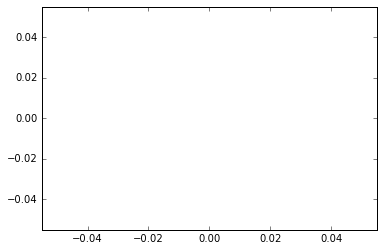

In [284]:
groups = beers_sample.groupby('beer_style')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.cmpX, group.cmpY, marker='o', linestyle='', ms=12, label=name)

In [231]:
beers_sample.sort_values('cmpY',ascending = False)

,index,abv,availability,ba_score,beer_style,brewery_loation,brewery_name,brewery_website,for_trade,gots,...,num_reviews,pdev,ravg,reviews,soup,style_url,url,wants,cmpX,cmpY
13542,3621,7.50,Year-round,85,Oatmeal Stout,Pennsylvania,Tröegs Brewing Company,http://www.troegs.com,4,401,...,675,21.64,3.79,[ Had this on tap at Troegs' tasting room. S -...,NaN,/beer/style/69/,/beer/profile/694/52128/,74,112.243189,107.155385
15881,5740,5.00,Year-round,84,English India Pale Ale (IPA),United Kingdom (England),Samuel Smith Old Brewery (Tadcaster),,0,172,...,922,17.79,3.71,[ 330ml bottle poured into a 350ml beer glass....,NaN,/beer/style/150/,/beer/profile/113/573/,39,118.545731,86.644243
4976,14338,5.30,Year-round,87,American Porter,Oregon,Rogue Ales,http://www.rogue.com,3,361,...,1352,16.80,3.87,[ Dark brown. Smells of roasted coffee and mal...,NaN,/beer/style/159/,/beer/profile/132/353/,118,118.123761,85.345787
17822,7460,10.00,Year-round,87,Tripel,Belgium,Brouwerij Duvel Moortgat NV,,0,276,...,692,17.53,3.88,"[ L: deep copper color, clear , decent amount ...",NaN,/beer/style/58/,/beer/profile/222/2566/,66,102.182062,84.047321
3119,12703,10.00,Year-round,98,Quadrupel (Quad),Belgium,Brouwerij St. Bernardus NV,,48,2349,...,2718,17.42,4.42,"[ A - Chestnut brown pour, thick toffee colore...",NaN,/beer/style/142/,/beer/profile/259/1708/,729,126.991106,83.353382
14596,4450,7.20,Year-round,92,American Brown Ale,Delaware,Dogfish Head Craft Brewery,http://www.dogfish.com,6,1098,...,2018,18.54,4.10,"[ I normally HATE brown ales, but was pleasant...",NaN,/beer/style/73/,/beer/profile/64/1161/,335,97.728504,81.332576
5330,14693,9.50,Fall,93,American Double / Imperial Stout,Wisconsin,Central Waters Brewing Co.,http://www.centralwaters.com,93,792,...,645,17.18,4.19,[ The look is dark with minimal head upon pour...,NaN,/beer/style/157/,/beer/profile/652/16062/,427,104.534654,80.833654
8210,17356,5.00,Year-round,67,German Pilsener,Germany,Brauerei Beck & Co.,,0,375,...,681,40.14,2.84,[ Coors Light. The taste is non existant. I do...,NaN,/beer/style/41/,/beer/profile/32/2435/,17,100.391768,79.954784
1045,10850,7.00,Year-round,95,American IPA,California,Ballast Point Brewing Company,http://www.ballastpoint.com,25,2591,...,775,24.24,4.29,[ This is an exceptional beer especially on a ...,NaN,/beer/style/116/,/beer/profile/199/89174/,525,91.965053,79.857662
13177,3255,4.80,Year-round,79,German Pilsener,Germany,Bitburger Brauerei,,0,258,...,788,23.85,3.48,[ very light. lots of head. not terrible looki...,NaN,/beer/style/41/,/beer/profile/613/1641/,35,93.540184,79.701838
